# SAKI SS19 - adorsys Transaction Classification Challenge

### Objective
For a given set of financial transactions, classify each one into one of seven revenue (transaction) categories; these
categories are:
* Income
* Private (cash, deposit, donation, presents)
* Living (rent, additional flat expenses, ...)
* Standard of living (food, health, children, ...)
* Finance (credit, bank costs, insurances, savings)
* Traffic (public transport, gas stations, bike, car rent, ...)
* Leisure (hobby, sport, vacation, shopping, ...)

### Data Acquisition
* We start by importing our data with pandas and we print some information about the dataset.
* For aesthetic reasons, the shape and info are commented out. Feel free to uncomment them to have more insights on the data.

In [1]:
import pandas as pd

PATH_TO_DATA = "data/oss-saki-ss19-exercise-1.csv"

dataSet = pd.read_csv(PATH_TO_DATA, delimiter=';')


### Sampling
In order to avoid any assumptions that can be made about the data, we randomly split the data into
training and test sets. 
The test data is then saved in a different csv files.


In [2]:
dataSet.head()
# print(dataSet.shape)
# dataSet.info()

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


### Data Exploration
* To obtain a better understanding of our data, we need to do some exploration.
* One might argue that some the tasks performed here belong to feature engineering or to another machine learning phase, 
    and the argument will be legitimate. It is merely done here to explore the date unencumbered.

1. Removing the columns with little or no value
The following columns might not be very useful for our model training:

- **Auftragskonto**: Is the account number of the person or entity that performs the transaction. You can
see that there are just a few account numbers.

In [3]:
uniqueAccountNumbers = len(dataSet["Auftragskonto"].unique())
missingAccountNumbers = dataSet["Auftragskonto"].isnull().sum()
print("There are " + str(uniqueAccountNumbers) + " unique account numbers.")
print("There are " + str(missingAccountNumbers) + " missing values.")

There are 3 unique account numbers.
There are 41 missing values.


- **Unnamed:0**: Is just a row identifier

- **Valutadatum**: Valutadatum and Buchungstag have the same values except for one. However, Buchungstag is discarded
 since (in my opinion, semantically) would correspond to the actual date of the transaction.

In [4]:
sameDateOnBothColumns = dataSet[dataSet["Valutadatum"] != dataSet["Buchungstag"]]
print("How many rows have different dates ? " + str(len(sameDateOnBothColumns)))

How many rows have different dates ? 1


- **Kontonummer and BLZ**: Both values generally tie to a bank a specific account in a bank branch. The same bank 
in different cities might have different BLZ. My assumption is that these values may over fit the
model on the training set.

- **Waehrung**: This is the currency and given our data, it might not be very helpful during predictions.

In [5]:
uniqueCurrencies = len(dataSet["Waehrung"].unique())
print("There is only " + str(uniqueCurrencies) + " currency.")

There is only 1 currency.


In [6]:
dataSetWithMeaningfulColumns = dataSet.drop(columns=["Auftragskonto", "Unnamed: 0", "Valutadatum",
                                                     "Kontonummer", "BLZ", "Waehrung"])
dataSetWithMeaningfulColumns.head()

,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Betrag,label
0,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,2000.00,income
1,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,-670.00,living
2,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,-70.00,private
3,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,-73.21,standardOfLiving
4,18.07.2016,Spontanausgabe,Amazon,neue Playstation,-363,leisure


2. Searching for outliers
Now, let us search for outliers in the **Betrag** column. We start by plotting a box plot for this attribute.
(Some cleaning has to be done on the amount as some numbers have commas while others have a dot for floating points.)

In [7]:
import seaborn as sns
sns.set(style="whitegrid")
dataSetWithMeaningfulColumns["Betrag"] = dataSetWithMeaningfulColumns["Betrag"].apply(lambda amount: amount.replace(',','.'))
dataSetWithMeaningfulColumns["Betrag"] = dataSetWithMeaningfulColumns["Betrag"].astype("float")
dataSetWithMeaningfulColumns["label"] = dataSetWithMeaningfulColumns["label"].astype("category")
amountVsLabelPlot = sns.scatterplot(x="label", y="Betrag", data=dataSetWithMeaningfulColumns.sort_values("Betrag"))

def rotate_labels(plot):
    for item in plot.get_xticklabels():
        item.set_rotation(35)
rotate_labels(amountVsLabelPlot)

On the first sight, it looks like the points at -5000€ and -4000€ could be outliers. 
However, -4000€ falls in the finance category. After investigation, we notice that it is indeed a money investment. 
We are therefore left with the former case (-5000€). Before drawing any conclusions we draw another plot based on 
the days of the month.

In [8]:
missingAccountNumbers = dataSet["Buchungstag"].isnull().sum()
print("There are " + str(missingAccountNumbers) + " missing dates.")

There are 0 missing dates.


I speculate that the full date will not be useful for categorization. The day of the month however can have some interesting
properties. For example, regular worker salaries usually come up around the end of the month (or at the beginning of the new month). For
this reason, a new attribute **dayOfMonth** is created and meanwhile **Buchungstag** will be discarded. 
There are no missing values, so one can safely extract the day.

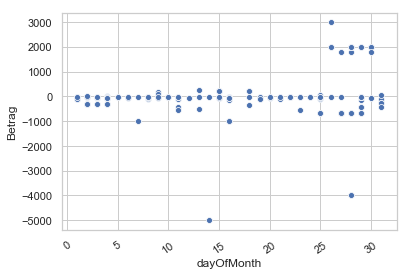

In [9]:
dataSetWithMeaningfulColumns["dayOfMonth"] = dataSetWithMeaningfulColumns["Buchungstag"].apply(lambda date: date[0:2])
dataSetWithMeaningfulColumns["dayOfMonth"] = dataSetWithMeaningfulColumns["dayOfMonth"].astype("int")
dayVsAmountPlot = sns.scatterplot(x="dayOfMonth", y="Betrag", data=dataSetWithMeaningfulColumns.sort_values("dayOfMonth"))
rotate_labels(dayVsAmountPlot)

As expected, a lot more happens towards the end of the months. The transaction with -5000€ still stands out.

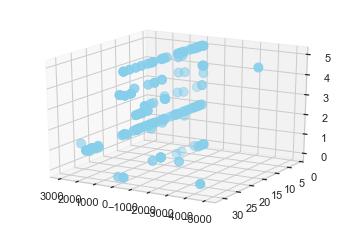

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataSetWithMeaningfulColumns["Betrag"], dataSetWithMeaningfulColumns["dayOfMonth"], dataSetWithMeaningfulColumns["label"].cat.codes, c='skyblue', s=80)
ax.view_init(20, 120)
plt.show()

After plotting the day against the amount and label (irrespective of their encoding 0-5) I assume that
the transaction with -5000€ is an outlier. It does not quite fit to the other points belonging to the category 
standardOfLiving. For this reason, this row will be removed before training.

In [11]:
print("Shape before removing outliers" + str(dataSetWithMeaningfulColumns.shape))
dataSetWithoutOutlier = dataSetWithMeaningfulColumns[dataSetWithMeaningfulColumns["Betrag"] > -5000]
print("Shape after removing outliers" + str(dataSetWithoutOutlier.shape))

Shape before removing outliers(209, 7)
Shape after removing outliers(208, 7)


3. We now look at the distribution of **Betrag**. Having a normal distribution could be important
if we decide to chose a classifier which assumes normality (Gaussian Naive Bayes in our case). 


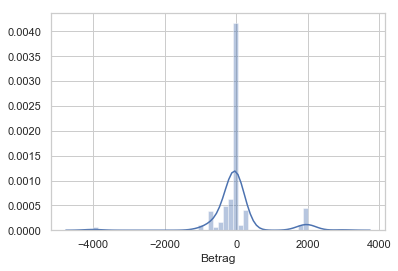

In [12]:
ax = sns.distplot(dataSetWithoutOutlier["Betrag"])

The histogram tells us that cash outflows are more frequent than inflows. We can also look at the mean and median.

In [13]:
print("The mean of Betrag is: " + str(dataSetWithoutOutlier["Betrag"].mean(skipna=True)))
print("The median of Betrag is " + str(dataSetWithoutOutlier["Betrag"].median(skipna=True)))


The mean of Betrag is: 28.008846153846154
The median of Betrag is -28.85


4. At last we look at the distribution of the labels in our dataset


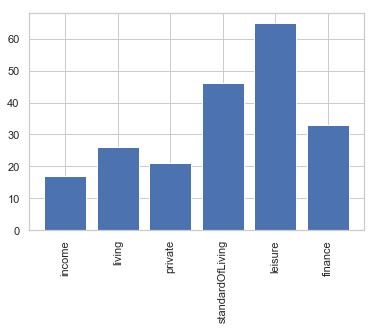

In [14]:
from collections import Counter
import numpy as np
def plot_frequencies(data):
    counter = Counter(data)
    tokens = counter.keys()
    token_counts = counter.values()
    indexes = np.arange(len(tokens))
    plt.bar(indexes, token_counts)
    plt.xticks(indexes, tokens, rotation="vertical")
    plt.show()
plot_frequencies(dataSetWithoutOutlier["label"])


This plot shows that our labels are imbalanced; something to considered when sampling the data.

### Data Cleaning
* Two main attributes will be involved (**Verwendungszweck** and **Buchungstext**)
* All non alphabetical characters are deleted from the **Buchungstext** so that we keep (more or less) full words or tokens
* As for the Verwendungszweck, more work has to be done.
    * Then replace all non alphabetical characters with spaces. For example "A/9B" will then be "A  B"
    * At last, stopwords (assuming german language) are removed and german characters are normalized (i.e ä to ae etc.). 

In [15]:
def replace_non_alpha_with_space(text: str):
    return "".join([c if c.isalpha() else " " for c in text])

def normalize_german_characters(text: str):
    text = text.replace('ä', 'ae')
    text = text.replace('ö', 'oe')
    text = text.replace('ü', 'ue')
    text = text.replace('Ä', 'Ae')
    text = text.replace('Ö', 'Oe')
    text = text.replace('Ü', 'Ue')
    text = text.replace('ß', 'ss')
    return text

def remove_words_from_text(text: str, words: list):
    return " ".join([token for token in text.lower().split() if token not in words])

def remove_one_and_two_char_tokens(text: str):
    return " ".join([token for token in text.split() if len(token) > 2])

from nltk.corpus import stopwords
germanStopWords = stopwords.words('german')
dataSetWithoutOutlier.Buchungstext = dataSetWithoutOutlier.Buchungstext.apply(lambda text: replace_non_alpha_with_space(text))
dataSetWithoutOutlier.Buchungstext = dataSetWithoutOutlier.Buchungstext.apply(lambda text: remove_words_from_text(text, germanStopWords))
dataSetWithoutOutlier.Buchungstext = dataSetWithoutOutlier.Buchungstext.apply(lambda text: normalize_german_characters(text))
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: replace_non_alpha_with_space(text))
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: normalize_german_characters(text))
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: remove_words_from_text(text, germanStopWords))
dataSetWithoutOutlier.head()

/Users/pascalzoleko/PycharmProjects/saki2019/venv/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Betrag,label,dayOfMonth
0,28.07.2016,lohn gehalt,gehalt adorsys gmbh co kg end to end ref notpr...,Adorsys GmbH & Co. KG,2000.00,income,28
1,27.07.2016,miete,byladem sbt de miete beuthener str end to end ...,Georg Tasche,-670.00,living,27
2,21.07.2016,bargeld,uhr nuernberg all eur geb eur einzahlung ausza...,Bargeld,-70.00,private,21
3,20.07.2016,lebensmittel getraenke,edeka neubauer nuernb nuernb t kfn vj lastschrift,Kartenzahlung,-73.21,standardOfLiving,20
4,18.07.2016,spontanausgabe,amazon,neue Playstation,-363.00,leisure,18


We now look at how the words are distributed for each variable.
* For **Buchungstext**

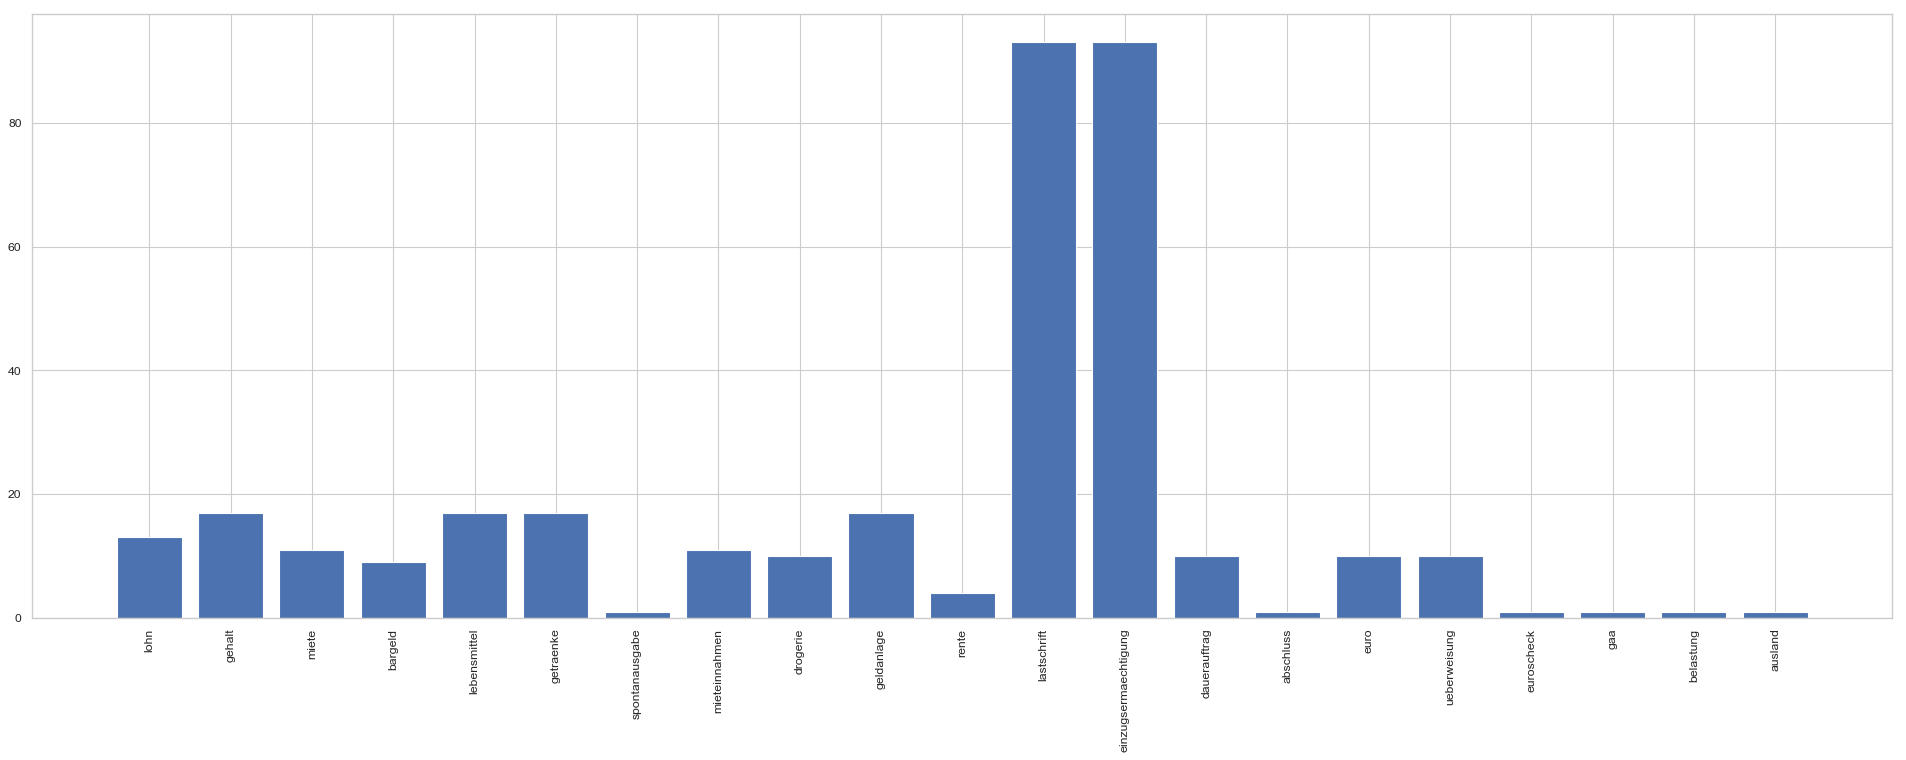

In [16]:
from matplotlib.pyplot import figure
def plot_token_frequencies(data):
    figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    plot_frequencies([token for i, text in enumerate(data) for token in text.split()])
plot_token_frequencies(dataSetWithoutOutlier["Buchungstext"])

* For **Verwendungszweck**

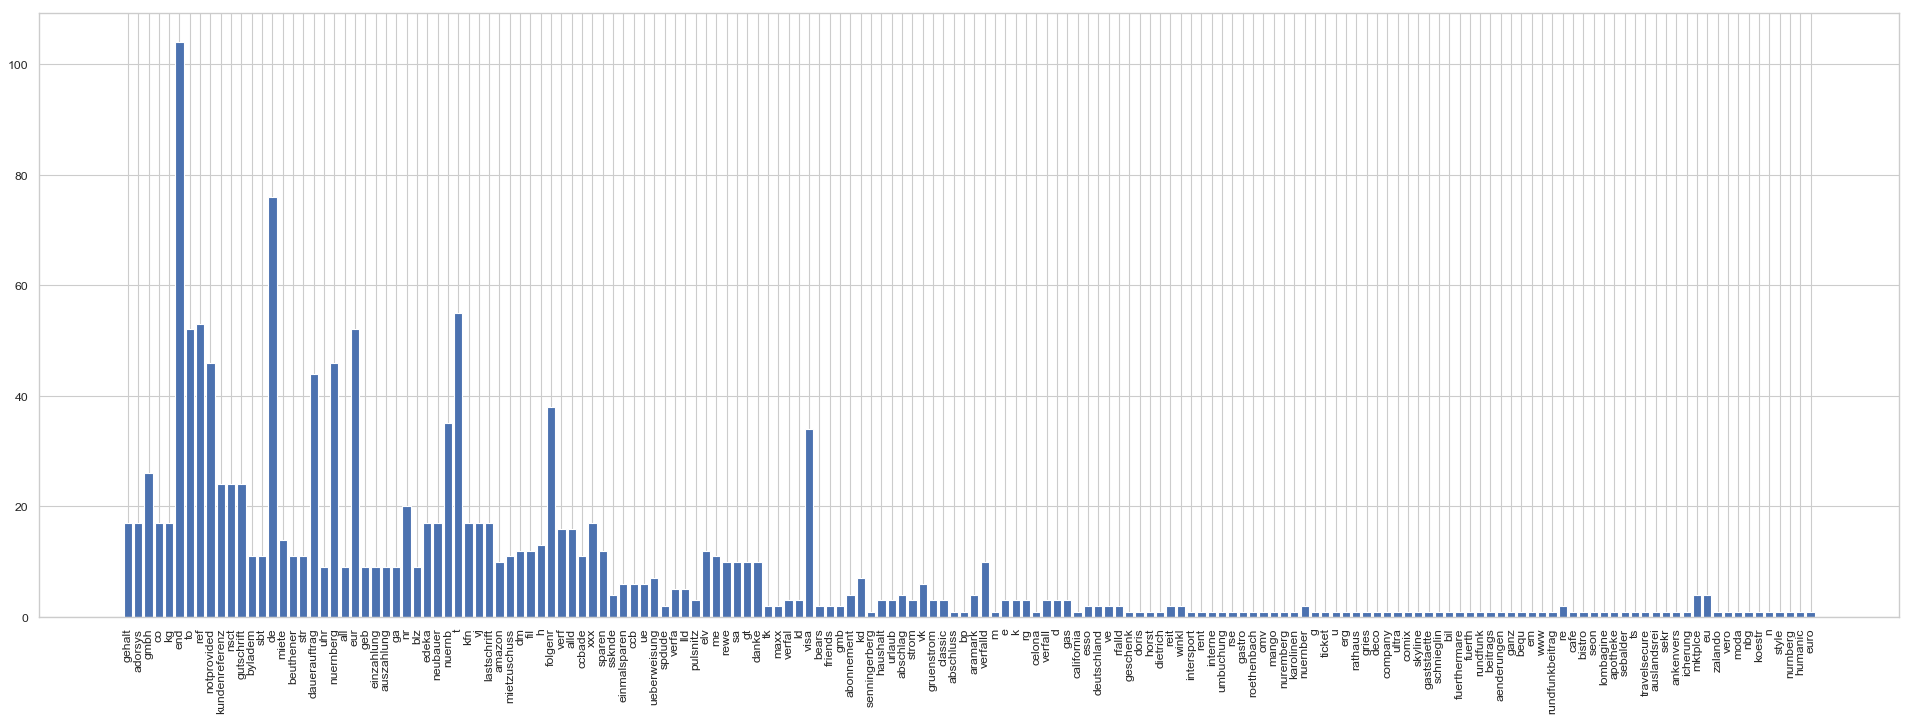

In [17]:
plot_token_frequencies(dataSetWithoutOutlier["Verwendungszweck"])

After taking a look at the distribution, one might notice that many words with higher frequencies tend to be less
relevant (in my opinion, based on transaction semantics) when compared to some words having lower frequencies. 
I will also assume that one and two character tokens won't be very useful for the model, since they hold no semantical
meaning (in my opinion).

In [18]:
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: remove_one_and_two_char_tokens(text))

Given that the space of words is small, i can afford to manually select words I deem relevant for the classifier. 
The selection is merely based on intuition and other factors (online search, IBAN/BICs, redundant 
tokens e.g "bears friends" etc.).
The following words are most likely going to overfit the model and hence will be deleted from the Verwendungszweck.

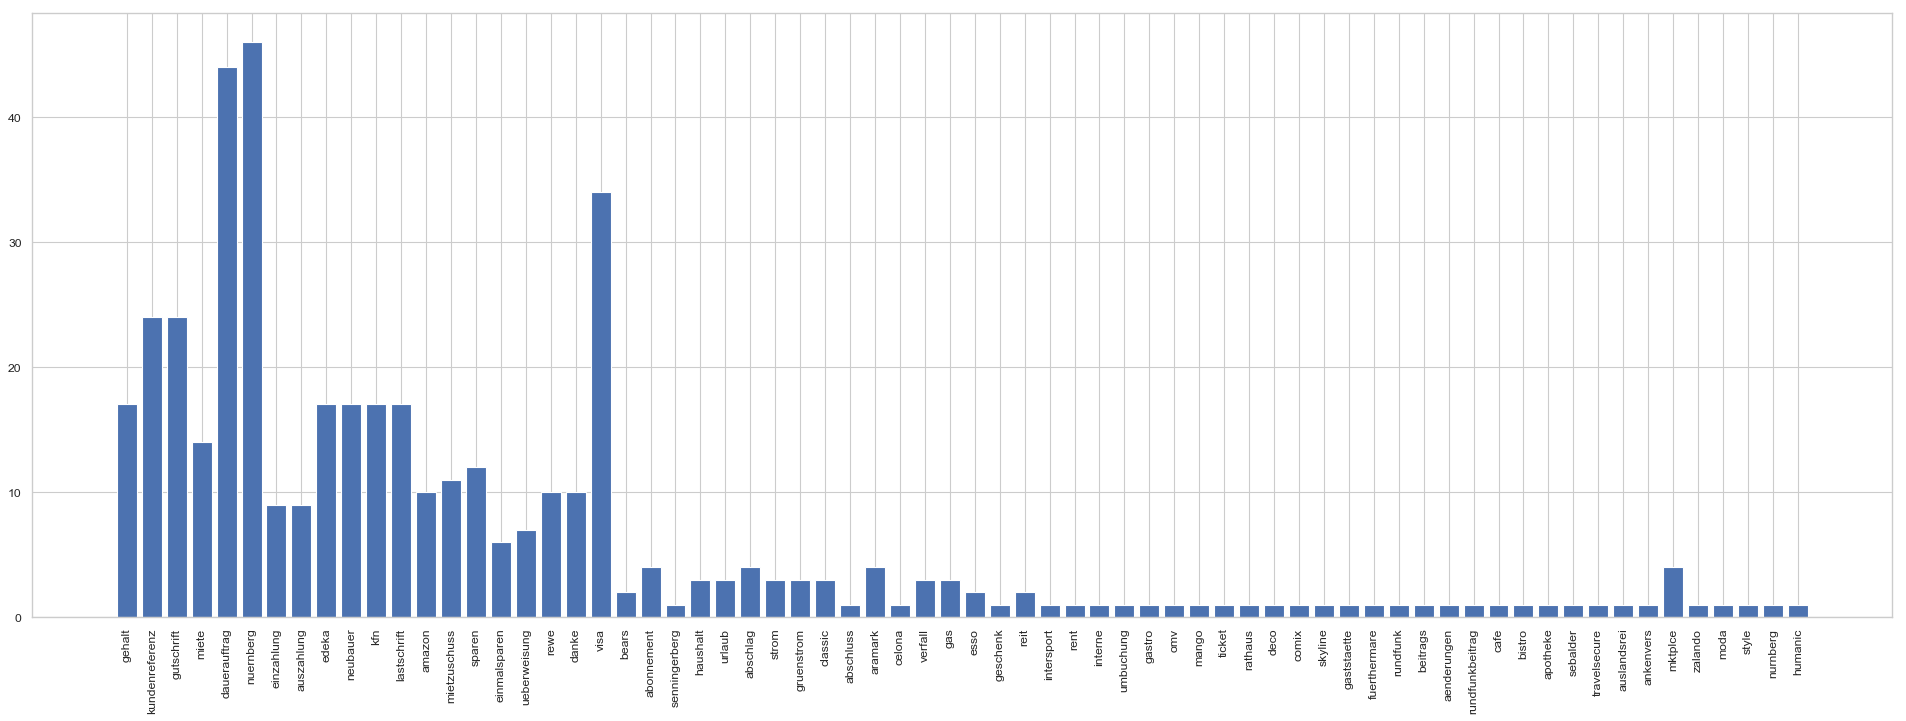

In [19]:
unwantedWords = "All Eur Geb Blz Nuernb Fil Folgenr Verf Alld ccbade xxx ccb spdude verfa lld pulsnitz elv maxx verfal " \
                "friends gmbAramark gmbh verfalld California Rfalld Doris Horst Dietrich Winkl Deutschland " \
                "rse Roethenbach Nuremberg Karolinen End adorsys Notprovided Nsct Byladem sbt ssknde Beuthener str Uhr " \
                "Nuerenberg Nuernber erg gries company ultra Schnieglin bil Fuerth ganz bequ www seon Lombagine Sebalder" \
                "Auslandsrei Sekr Icherung vero nbg koestr euro ref gmb"
unwantedWords = unwantedWords.split()
unwantedWords = [word.lower() for word in unwantedWords]
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: remove_words_from_text(text, unwantedWords))
plot_token_frequencies(dataSetWithoutOutlier["Verwendungszweck"])

### Feature Engineering
* Now that the data is cleaner, we select, extract and transform the necessary features we will later feed into the model.

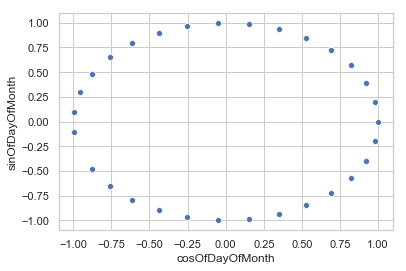

In [20]:
dataWithSelectedFeatures = pd.DataFrame()
dataWithSelectedFeatures["sinOfDayOfMonth"] = np.sin(dataSetWithoutOutlier.dayOfMonth*(2.0 * np.pi / 31))
dataWithSelectedFeatures["cosOfDayOfMonth"] = np.cos(dataSetWithoutOutlier.dayOfMonth*(2.0 * np.pi / 31))
dayOfMonthFeatures = sns.scatterplot(x="cosOfDayOfMonth", y="sinOfDayOfMonth", data=dataWithSelectedFeatures.sort_values("cosOfDayOfMonth"))

Now that the circular nature of dates has been captured in the two features **sinOfDayOfMonth** and **cosOfDayOfMonth**,
We now move next to the amount (Betrag).

In [21]:
print(dataSetWithoutOutlier.Betrag.describe())

count     208.000000
mean       28.008846
std       742.248428
min     -4000.000000
25%       -92.492500
50%       -28.850000
75%       -12.205000
max      2986.240000
Name: Betrag, dtype: float64


Betrag has a high standard deviation and variance. When the distribution of the amount was plotted, we noticed heavy 
tails. To stabilize the variance, we apply a log transformation. But before doing that, two more features will be 
extracted from the amount.
* A binary feature decimalInAmount that is 1 if the amount is not a whole number and 0 otherwise. 
For example, 1 for 23.56 and 0 for 23.00. This feature is extracted because (I speculate that) many transactions
like rent are often whole numbers, compared to leisure transactions.
* Since the log transformation only works for positive numbers, the sign of the amount must be extracted before.
(where 0 is considered positive to keep things simple). The sign is encoded as a binary feature.

,sinOfDayOfMonth,cosOfDayOfMonth,decimalInAmount,amountSign,absoluteAmount
0,-0.571268,0.820763,0,1,7.600902
1,-0.724793,0.688967,0,0,6.507278
2,-0.897805,-0.440394,0,0,4.248495
3,-0.790776,-0.612106,1,0,4.293332
4,-0.485302,-0.874347,0,0,5.894403


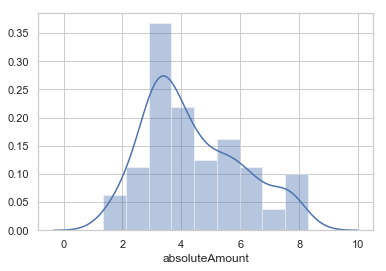

In [22]:
dataWithSelectedFeatures["decimalInAmount"] = [1 if amount - float(int(amount)) != 0. else 0 for amount in dataSetWithoutOutlier.Betrag]
dataWithSelectedFeatures["amountSign"] = dataSetWithoutOutlier.Betrag.apply(lambda s: 1 if s >= 0 else 0)
dataWithSelectedFeatures["absoluteAmount"] = dataSetWithoutOutlier.Betrag.apply(lambda a: np.log(np.abs(a)))
absoluteAmountDistribution = sns.distplot(dataWithSelectedFeatures["absoluteAmount"])
dataWithSelectedFeatures.head()

This now looks a little better than what we had before (meaning the tails are gone and the distribution 
looks more normal).

We now convert **Buchungstext** and **Verwendungszweck** into a matrix of tokens. And we assume that 
the text consists of **german** words.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
def get_feature_matrix_from_corpus(corpus: pd.DataFrame) -> pd.DataFrame:
    vectorizer = CountVectorizer()
    text_matrix = vectorizer.fit_transform(corpus)
    text_features = vectorizer.get_feature_names()
    return pd.DataFrame(data=text_matrix.toarray(), columns=text_features)

vzAndBText = pd.DataFrame()
vzAndBText["vzAndBt"] = dataSetWithoutOutlier.Verwendungszweck + " " + dataSetWithoutOutlier.Buchungstext
vzAndBTextDF = get_feature_matrix_from_corpus(vzAndBText.vzAndBt)

Some features here may be redundant, for example (**Lebensmittel**, **Getraenke**), 
(**Lastschrift**, **Einzugsermächtigung**) and (**Euro**, **Überweisung**). That is an assumption made based
on the current data. To have a model that generalizes better, I will drop (**Euro**, **Einzugsermächtigung** and
**Getraenke**) as special cases of the aforementioned (or maybe just mean the same). You can verify if you look at the 
distribution plotted earlier. 

In [24]:
vzAndBTextDF = vzAndBTextDF.drop(columns=["euro", "einzugsermaechtigung", "getraenke"])
vzAndBTextDF.head()

,abonnement,abschlag,abschluss,aenderungen,amazon,ankenvers,apotheke,aramark,ausland,auslandsrei,...,strom,style,ticket,travelsecure,ueberweisung,umbuchung,urlaub,verfall,visa,zalando
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The last raw feature is **Beguenstigter/Zahlungspflichtiger**. We are simply going to exclude this feature. Here is why:
* A name either belongs to a natural or legal person. This characteristic is partly handled by the keyword **Lastschrift**
since natural persons in europe very rare get SEPA Lastschrift. In other words, having the key word Lastschrift implicitly
mean the row transaction is for/from a company or firm.
* Another way to solve this would be to run Named Entity Recognition over the reference name column 
(**Beguenstigter/Zahlungspflichtiger**). I tried this indeed with **Zalando Flair** an Natural Language Processing
Library and had a percentage decrease of roughly **7%** (This could have been dependent on the run, but my assumption is
that keeping the names might just lead to overfitting. With more data, keeping it could have been an option).
Moreover, since **Flair** uses deep learning to extract entities,
it takes too much time. Hence I deleted it from this pipeline.

The operation above cost a lot of computational resources. This operation can thus be skipped to improve performance.
However, take note that the **isPersonalTransaction** feature will be absent when training.
Furthermore note that a name can be wrongly classified as person (e.g "Bargeld"), but my assumption is that binary 
values should generalize better than a long list of names.

Now we combine the features to get our final data frame

In [25]:
from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(dataSetWithoutOutlier["label"])
encodedLabels = labelEncoder.transform(dataSetWithoutOutlier["label"])
labels = pd.DataFrame()
labels["label"] = encodedLabels
labels["label"] = labels["label"].astype("int")
dataWithSelectedFeatures.reset_index(drop=True, inplace=True)
vzAndBTextDF.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)
finalDataSet = pd.concat([dataWithSelectedFeatures, vzAndBTextDF, labels], axis=1, sort=False)
finalDataSet.head()

,sinOfDayOfMonth,cosOfDayOfMonth,decimalInAmount,amountSign,absoluteAmount,abonnement,abschlag,abschluss,aenderungen,amazon,...,style,ticket,travelsecure,ueberweisung,umbuchung,urlaub,verfall,visa,zalando,label
0,-0.571268,0.820763,0,1,7.600902,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.724793,0.688967,0,0,6.507278,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,-0.897805,-0.440394,0,0,4.248495,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,-0.790776,-0.612106,1,0,4.293332,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,-0.485302,-0.874347,0,0,5.894403,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


Now we are done, we export the final data set as csv.

In [26]:
finalDataSet.to_csv("./data/ready3_for_training.csv", index=False)


### Training
* We train our data with a gaussian naive bayes classier.

In [27]:
PATH_TO_TRAINING_DATA = "./data/ready3_for_training.csv"
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
trainingSet = pd.read_csv(PATH_TO_TRAINING_DATA)
labelSet = trainingSet["label"].copy()
trainingSet = trainingSet.drop(columns=["label"])
X_train, X_test, y_train, y_test = train_test_split(trainingSet, labelSet, test_size=0.30, random_state=None)
clf = GaussianNB().fit(X_train, y_train)
labels_predicted = clf.predict(X_test)
print(np.mean(labels_predicted == y_test))
print(confusion_matrix(y_test, labels_predicted))

0.8095238095238095
[[13  0  0  0  0  1]
 [ 0  2  0  0  0  0]
 [ 0  0 17  0  1  3]
 [ 0  0  1  0  5  1]
 [ 0  0  0  0  7  0]
 [ 0  0  0  0  0 12]]
